# NBA Fantasy Draft Tool - 2025-26 Season
## Yahoo! Fantasy Basketball - Advanced Analytics

This notebook provides:
1. Player rankings optimized for Yahoo scoring
2. Consistency analysis (favoring predictable performers)
3. Injury risk modeling
4. Real-time draft tracker

**League Settings:**
- Scoring: PTS(1), REB(1.2), AST(1.5), STL(3), BLK(3), TO(-1)
- Roster: PG, SG, G, SF, PF, F, C, C, UTIL, UTIL, BN, BN, BN
- Draft: Live Standard, 12 teams

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


## Step 1: Data Collection

**Note:** First run may take 15-30 minutes to scrape all data.
Data will be cached for subsequent runs.

In [6]:
from data_collector import NBADataCollector
import os

# Check if data already exists
data_dir = 'data'
if os.path.exists(f'{data_dir}/game_logs.parquet'):
    print("Loading cached data...")
    game_logs = pd.read_parquet(f'{data_dir}/game_logs.parquet')
    standings = pd.read_csv(f'{data_dir}/standings.csv') if os.path.exists(f'{data_dir}/standings.csv') else None
    injury_data = pd.read_csv(f'{data_dir}/injury_data.csv') if os.path.exists(f'{data_dir}/injury_data.csv') else None
    print(f"✓ Loaded {len(game_logs):,} game logs")
else:
    print("Collecting fresh data (this will take ~20 minutes)...")
    collector = NBADataCollector(
        seasons=[2024, 2025],
        weights={2025: 0.60, 2024: 0.40}
    )
    data = collector.collect_all_data()
    collector.save_data(data, output_dir=data_dir)
    
    game_logs = data['game_logs']
    standings = data['standings']
    injury_data = data['injury_data']
    print("✓ Data collection complete!")

print(f"\nData Summary:")
print(f"  - Total games: {len(game_logs):,}")
print(f"  - Unique players: {game_logs['player_name'].nunique()}")
print(f"  - Seasons: {sorted(game_logs['season_end_year'].unique())}")

Loading cached data...
✓ Loaded 60,312 game logs

Data Summary:
  - Total games: 60,312
  - Unique players: 687
  - Seasons: [np.int64(2024), np.int64(2025)]


In [7]:
# Fixed diagnostic code - handles Team enum objects
print("=== CHECKING DATA STRUCTURE ===\n")

# Check game logs structure
print("Game logs columns:", game_logs.columns.tolist())
print("\nSample team values from game logs:")
print(game_logs['team'].value_counts().head(10))

# Check the type of team values
print("\nType of team values:", type(game_logs['team'].iloc[0]))

# Check standings structure  
print("\n\nStandings columns:", standings.columns.tolist())
print("\nStandings shape:", standings.shape)

# Check for team name format mismatch
print("\n=== TEAM NAME FORMAT CHECK ===")

# Convert Team objects to strings for inspection
game_log_teams = set()
for team in game_logs['team'].dropna().unique():
    # Convert Team enum to string
    team_str = str(team)
    game_log_teams.add(team_str)

print(f"Sample game log team formats: {list(game_log_teams)[:5]}")

# Get unique team names from standings
standings_teams = set()
for col in ['Eastern Conference', 'Western Conference']:
    if col in standings.columns:
        teams = standings[col].dropna().str.strip().str.rstrip('*').unique()
        standings_teams.update(teams)

print(f"\nSample standings team formats: {list(standings_teams)[:5]}")

# Try to match a few teams
print("\n=== TESTING TEAM MATCHING ===")
test_team = list(game_log_teams)[0] if game_log_teams else None
if test_team:
    print(f"Game log format: {test_team}")
    
    # Process the team string
    if 'Team.' in test_team:
        clean_name = test_team.replace('Team.', '').replace('_', ' ').title()
        print(f"Cleaned format: {clean_name}")
        print(f"Match found in standings: {clean_name in standings_teams}")
    else:
        print("Team format doesn't start with 'Team.'")

# Show how Team enum values look when converted to string
print("\n=== SAMPLE TEAM CONVERSIONS ===")
for i, team in enumerate(game_logs['team'].dropna().unique()[:5]):
    team_str = str(team)
    if 'Team.' in team_str:
        clean = team_str.replace('Team.', '').replace('_', ' ').title()
        print(f"{team_str} -> {clean}")

=== CHECKING DATA STRUCTURE ===

Game logs columns: ['date', 'team', 'location', 'opponent', 'outcome', 'active', 'seconds_played', 'made_field_goals', 'attempted_field_goals', 'made_three_point_field_goals', 'attempted_three_point_field_goals', 'made_free_throws', 'attempted_free_throws', 'offensive_rebounds', 'defensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls', 'points_scored', 'game_score', 'plus_minus', 'player_name', 'player_slug', 'season_end_year', 'fantasy_points', 'season_weight']

Sample team values from game logs:
team
Team.TORONTO_RAPTORS         2297
Team.WASHINGTON_WIZARDS      2291
Team.PHILADELPHIA_76ERS      2262
Team.DETROIT_PISTONS         2143
Team.DALLAS_MAVERICKS        2133
Team.CHARLOTTE_HORNETS       2126
Team.SACRAMENTO_KINGS        2109
Team.MILWAUKEE_BUCKS         2105
Team.LOS_ANGELES_CLIPPERS    2105
Team.PHOENIX_SUNS            2096
Name: count, dtype: int64

Type of team values: <class 'str'>


Standings columns: ['Eastern 

In [8]:
# Run this BEFORE the feature engineering step to convert Team enums to strings
# This will make the data easier to work with

print("Converting Team enum objects to strings...")

# Convert team column to string
if 'team' in game_logs.columns:
    game_logs['team'] = game_logs['team'].astype(str)
    print(f"✓ Converted {len(game_logs)} team values to strings")
    
    # Show sample values
    print("\nSample converted team values:")
    print(game_logs['team'].value_counts().head(5))

# Also convert opponent column if it exists
if 'opponent' in game_logs.columns:
    game_logs['opponent'] = game_logs['opponent'].astype(str)
    print(f"✓ Converted opponent values to strings")

# Convert location column if it exists and is enum
if 'location' in game_logs.columns:
    try:
        game_logs['location'] = game_logs['location'].astype(str)
        print(f"✓ Converted location values to strings")
    except:
        pass

# Convert outcome column if it exists and is enum  
if 'outcome' in game_logs.columns:
    try:
        game_logs['outcome'] = game_logs['outcome'].astype(str)
        print(f"✓ Converted outcome values to strings")
    except:
        pass

print("\nConversion complete. You can now proceed with feature engineering.")

Converting Team enum objects to strings...
✓ Converted 60312 team values to strings

Sample converted team values:
team
Team.TORONTO_RAPTORS       2297
Team.WASHINGTON_WIZARDS    2291
Team.PHILADELPHIA_76ERS    2262
Team.DETROIT_PISTONS       2143
Team.DALLAS_MAVERICKS      2133
Name: count, dtype: int64
✓ Converted opponent values to strings
✓ Converted location values to strings
✓ Converted outcome values to strings

Conversion complete. You can now proceed with feature engineering.


## Step 2: Feature Engineering

Creating advanced features:
- **Consistency Score**: Statistical measure of reliability
- **Optimized Moving Averages**: ML-weighted recent performance
- **Injury Risk Score**: Based on games missed and playing time volatility
- **Age Adjustment**: Peak performance curves (25-29 years old)

In [9]:
from feature_engineering import FantasyFeatureEngineer

print("Engineering features...")
engineer = FantasyFeatureEngineer(
    game_logs_df=game_logs,
    injury_df=injury_data,
    standings_df=standings
)

player_features = engineer.create_all_features()

# Display sample
print("\nSample Player Features:")
display(player_features.head(10))

# Save features
player_features.to_csv('data/player_features.csv', index=False)
print("\n✓ Features saved to data/player_features.csv")

Engineering features...

Creating advanced features...
Processing standings data...
Found 60 team-season combinations
✓ Marked 23860/60312 games as contender teams
Created features for 687 players

Sample Player Features:


,player_name,player_slug,consistency_score,floor,ceiling,avg_fp,median_fp,std_fp,coef_variation,iqr_ratio,games_played,optimized_ma_fp,optimized_ma_points,optimized_ma_rebounds,optimized_ma_assists,injury_risk_score,games_played_count,is_contender,team
0,A.J. Green,greenaj01,7.080486,5.0,24.0,14.013699,13.0,7.131818,0.508918,0.692308,73.0,126.050030,-2.601942,2.900000,-0.378572,15.252949,73,True,Team.MILWAUKEE_BUCKS
1,A.J. Lawson,lawsoaj01,6.105152,1.5,33.0,16.384615,17.0,12.685779,0.774249,1.132353,26.0,18.245813,10.361582,0.840669,1.609027,70.000000,26,False,Team.TORONTO_RAPTORS
2,AJ Griffin,griffaj01,1.243018,0.0,8.2,3.850000,3.5,3.409912,0.885691,1.428571,20.0,3.813875,2.403221,0.050496,0.212883,70.000000,20,False,Team.ATLANTA_HAWKS
3,AJ Johnson,johnsaj01,5.991394,1.7,30.3,15.206897,17.0,10.610273,0.697728,1.117647,58.0,19.865981,10.654105,0.282996,3.614156,55.000000,58,False,Team.WASHINGTON_WIZARDS
4,Aaron Gordon,gordoaa01,14.727156,12.0,41.0,26.686275,27.0,11.079906,0.415191,0.555556,51.0,20.033072,13.043149,0.931434,0.361328,64.619514,51,True,Team.DENVER_NUGGETS
5,Aaron Holiday,holidaa01,4.250237,2.1,18.9,10.274194,8.0,7.584299,0.738189,1.093750,62.0,10.860187,6.049697,0.416043,4.693070,35.000000,62,True,Team.HOUSTON_ROCKETS
6,Aaron Nesmith,nesmiaa01,12.044919,10.8,34.2,21.022222,19.0,8.530960,0.405807,0.631579,45.0,46.886681,19.185838,0.122022,0.459108,64.810601,45,True,Team.INDIANA_PACERS
7,Aaron Wiggins,wiggiaa01,10.724750,7.5,34.5,21.605263,20.0,11.639406,0.538730,0.700000,76.0,-47.029350,16.987545,1.387304,0.794423,15.186927,76,True,Team.OKLAHOMA_CITY_THUNDER
8,Adam Flagler,flaglad01,0.597126,0.0,8.8,3.918919,1.0,6.811669,1.738150,4.000000,37.0,5.896535,2.987745,0.212700,0.768571,70.000000,37,True,Team.OKLAHOMA_CITY_THUNDER
9,Adama Sanogo,sanogad01,0.000000,0.0,0.0,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,50.000000,4,False,Team.CHICAGO_BULLS



✓ Features saved to data/player_features.csv


## Step 3: Machine Learning Model

Train XGBoost model to project 2025-26 fantasy points

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# ============================================================================
# ENHANCED FEATURE ENGINEERING
# ============================================================================

def create_advanced_features(player_features):
    """Add advanced statistical features for better predictions"""
    df = player_features.copy()
    
    # Recent form indicator (z-score of recent vs historical average)
    df['recent_form_zscore'] = (
        (df['optimized_ma_fp'] - df['avg_fp']) / (df['std_fp'] + 1)
    )
    
    # Consistency premium (reward low variance)
    df['consistency_premium'] = 1 / (df['coef_variation'] + 0.1)
    
    # Age curve adjustment (peak typically 26-29 for NBA players)
    if 'age' in df.columns:
        df['age_factor'] = np.where(
            df['age'].between(26, 29), 1.0,
            np.where(df['age'] < 26, 
                    0.95 + (df['age'] - 21) * 0.01,
                    1.0 - (df['age'] - 29) * 0.02)
        )
        df['age_factor'] = df['age_factor'].clip(0.75, 1.05)
    else:
        df['age_factor'] = 1.0
    
    # Usage proxy (higher involvement = higher fantasy value)
    df['usage_proxy'] = (
        df['optimized_ma_points'] + 
        df['optimized_ma_assists'] + 
        df['optimized_ma_rebounds']
    )
    
    # Upside indicator (ceiling relative to average)
    df['upside_ratio'] = df['ceiling'] / (df['avg_fp'] + 1)
    
    # Floor reliability (how close is floor to average)
    df['floor_reliability'] = df['floor'] / (df['avg_fp'] + 1)
    
    return df

# ============================================================================
# PREPARE DATA
# ============================================================================

# Enhanced feature set
feature_columns = [
    # Original features
    'avg_fp', 'median_fp', 'std_fp', 'floor', 'ceiling',
    'consistency_score', 'coef_variation', 'iqr_ratio',
    'optimized_ma_fp', 'optimized_ma_points', 'optimized_ma_rebounds', 'optimized_ma_assists',
    'injury_risk_score', 'games_played_count',
    # New advanced features
    'recent_form_zscore', 'consistency_premium', 'age_factor',
    'usage_proxy', 'upside_ratio', 'floor_reliability'
]

# NOTE: Make sure 'player_features' DataFrame is already loaded before running this code
# It should contain your historical player data with the basic features

# Verify player_features exists
if 'player_features' not in locals() and 'player_features' not in globals():
    raise NameError(
        "player_features DataFrame not found. Please load your data first.\n"
        "Example: player_features = pd.read_csv('your_player_data.csv')"
    )

# Apply feature engineering
print("Creating advanced features...")
player_features = create_advanced_features(player_features)

# Filter to players with minimum games played
min_games = 50
model_data = player_features[player_features['games_played_count'] >= min_games].copy()

X = model_data[feature_columns].fillna(0)
y = model_data['avg_fp']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

# ============================================================================
# MODEL 1: STACKED ENSEMBLE (PRIMARY PREDICTIONS)
# ============================================================================

print("\n" + "="*60)
print("Training Stacked Ensemble Model...")
print("="*60)

# Define diverse base models
base_models = [
    ('xgb', xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.05,
        max_depth=5,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )),
    ('lgb', lgb.LGBMRegressor(
        learning_rate=0.05,
        max_depth=6,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )),
    ('cat', CatBoostRegressor(
        learning_rate=0.05,
        depth=6,
        iterations=500,
        random_state=42,
        verbose=False
    ))
]

# Create stacked ensemble
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)

# Evaluate ensemble
y_pred_ensemble = stacking_model.predict(X_test)
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))

print(f"\nEnsemble Model Performance:")
print(f"  MAE: {mae_ensemble:.2f} fantasy points")
print(f"  RMSE: {rmse_ensemble:.2f} fantasy points")

# Generate primary projections
model_data['projected_fp'] = stacking_model.predict(X_scaled)

# ============================================================================
# MODEL 2: QUANTILE REGRESSION (CONFIDENCE INTERVALS)
# ============================================================================

print("\n" + "="*60)
print("Training Quantile Models for Risk Assessment...")
print("="*60)

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantile_models = {}

for q in quantiles:
    print(f"  Training {int(q*100)}th percentile model...")
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=q,
        learning_rate=0.05,
        max_depth=5,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    quantile_models[q] = model

# Generate confidence intervals
model_data['proj_p10'] = quantile_models[0.1].predict(X_scaled)
model_data['proj_p25'] = quantile_models[0.25].predict(X_scaled)
model_data['proj_p50'] = quantile_models[0.5].predict(X_scaled)
model_data['proj_p75'] = quantile_models[0.75].predict(X_scaled)
model_data['proj_p90'] = quantile_models[0.9].predict(X_scaled)

# Calculate risk metrics
model_data['upside'] = model_data['proj_p90'] - model_data['proj_p50']
model_data['downside'] = model_data['proj_p50'] - model_data['proj_p10']
model_data['risk_reward_ratio'] = model_data['upside'] / (model_data['downside'] + 1)
model_data['projection_range'] = model_data['proj_p90'] - model_data['proj_p10']

print("✓ Quantile models complete!")

# ============================================================================
# ADJUSTMENTS & DRAFT VALUE CALCULATIONS
# ============================================================================

print("\n" + "="*60)
print("Calculating Draft Values...")
print("="*60)

# Apply injury and age adjustments
model_data['adjusted_projection'] = (
    model_data['projected_fp'] *
    model_data['age_factor'] *
    (1 - model_data['injury_risk_score'] / 200)
)

# Calculate Value Over Replacement Player (VORP)
replacement_level = 120  # Adjust based on league size
if len(model_data) >= replacement_level:
    replacement_value = model_data.nlargest(replacement_level, 'adjusted_projection')['adjusted_projection'].min()
else:
    replacement_value = model_data['adjusted_projection'].quantile(0.25)

model_data['vorp'] = model_data['adjusted_projection'] - replacement_value

# Position scarcity adjustment (if position column exists)
if 'position' in model_data.columns:
    position_counts = model_data.groupby('position')['adjusted_projection'].transform('count')
    model_data['scarcity_adjusted_value'] = (
        model_data['vorp'] * (1 + 1 / np.sqrt(position_counts))
    )
else:
    model_data['scarcity_adjusted_value'] = model_data['vorp']

# Final draft ranking score (weighted combination)
model_data['draft_score'] = (
    model_data['scarcity_adjusted_value'] * 0.5 +
    model_data['proj_p50'] * 0.3 +
    model_data['risk_reward_ratio'] * 0.2
)

# ============================================================================
# CROSS-VALIDATION WITH TEMPORAL SPLITS
# ============================================================================

print("\n" + "="*60)
print("Performing Time-Series Cross-Validation...")
print("="*60)

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled), 1):
    X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train a quick XGBoost model for CV
    cv_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.05,
        max_depth=5,
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
    cv_model.fit(X_train_cv, y_train_cv, verbose=False)
    pred = cv_model.predict(X_val_cv)
    mae = mean_absolute_error(y_val_cv, pred)
    cv_scores.append(mae)
    print(f"  Fold {fold} MAE: {mae:.2f}")

print(f"\nTime-series CV Average MAE: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# ============================================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("Feature Importance (from XGBoost base model):")
print("="*60)

# Access the fitted estimator from the stacking model
xgb_fitted = stacking_model.named_estimators_['xgb']
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_fitted.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

# ============================================================================
# FINAL RANKINGS
# ============================================================================

print("\n" + "="*60)
print("FINAL PLAYER RANKINGS")
print("="*60)

# Sort by draft score
ranked_players = model_data.sort_values('draft_score', ascending=False).reset_index(drop=True)

# Display top players with key metrics
display_columns = [
    'player_name' if 'player_name' in ranked_players.columns else ranked_players.columns[0],
    'adjusted_projection', 'proj_p50', 'proj_p10', 'proj_p90',
    'vorp', 'risk_reward_ratio', 'draft_score'
]

display_columns = [col for col in display_columns if col in ranked_players.columns]

print("\nTop 20 Players:")
print(ranked_players[display_columns].head(20).to_string(index=True))

print("\n" + "="*60)
print("✓ Analysis Complete!")
print("="*60)

print(f"\nKey Metrics Stored in 'model_data':")
print("  - adjusted_projection: Age and injury adjusted fantasy points")
print("  - proj_p10/p50/p90: Confidence interval projections")
print("  - vorp: Value over replacement player")
print("  - risk_reward_ratio: Upside vs downside potential")
print("  - draft_score: Final composite draft ranking")
print("\nUse 'draft_score' for optimal draft order!")

Creating advanced features...
Training samples: 276, Test samples: 70

Training Stacked Ensemble Model...

Ensemble Model Performance:
  MAE: 0.22 fantasy points
  RMSE: 0.30 fantasy points

Training Quantile Models for Risk Assessment...
  Training 10th percentile model...
  Training 25th percentile model...
  Training 50th percentile model...
  Training 75th percentile model...
  Training 90th percentile model...
✓ Quantile models complete!

Calculating Draft Values...

Performing Time-Series Cross-Validation...
  Fold 1 MAE: 0.78
  Fold 2 MAE: 0.35
  Fold 3 MAE: 0.21
  Fold 4 MAE: 0.31
  Fold 5 MAE: 0.20

Time-series CV Average MAE: 0.37 ± 0.21

Feature Importance (from XGBoost base model):
            feature  importance
             avg_fp    0.513432
          median_fp    0.291980
  consistency_score    0.172568
            ceiling    0.020239
              floor    0.001568
             std_fp    0.000085
consistency_premium    0.000037
     coef_variation    0.000023
optimized

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare training data
feature_columns = [
    'avg_fp', 'median_fp', 'std_fp', 'floor', 'ceiling',
    'consistency_score', 'coef_variation', 'iqr_ratio',
    'optimized_ma_fp', 'optimized_ma_points', 'optimized_ma_rebounds', 'optimized_ma_assists',
    'injury_risk_score', 'games_played_count'
]

# Filter to players with minimum games played
min_games = 50
model_data = player_features[player_features['games_played_count'] >= min_games].copy()

X = model_data[feature_columns].fillna(0)
y = model_data['avg_fp']  # Target: average fantasy points

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (use 80% for training)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train XGBoost model with optimized parameters
print("Training XGBoost model...")
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    max_depth=5,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance:")
print(f"  MAE: {mae:.2f} fantasy points")
print(f"  RMSE: {rmse:.2f} fantasy points")

# Make predictions for all players
model_data['projected_fp'] = model.predict(X_scaled)

# Apply age and injury adjustments
model_data['adjusted_projection'] = (
    model_data['projected_fp'] * 
    (1 - model_data['injury_risk_score'] / 200)  # Reduce by up to 50% for high injury risk
)

print("\n✓ Projections complete!")

NameError: name 'player_features' is not defined

## Step 4: Player Rankings & Analysis

Generate draft rankings with position eligibility

In [12]:
# Calculate Value Over Replacement Player (VORP)
replacement_level = model_data['adjusted_projection'].quantile(0.40)
model_data['vorp'] = model_data['adjusted_projection'] - replacement_level

# Create composite draft score
# Weights: 50% projection, 30% consistency, 20% floor
model_data['draft_score'] = (
    0.50 * model_data['adjusted_projection'] +
    0.30 * model_data['consistency_score'] +
    0.20 * model_data['floor']
)

# Apply contender bonus (prefer players on playoff teams)
model_data['draft_score'] = np.where(
    model_data['is_contender'],
    model_data['draft_score'] * 1.05,
    model_data['draft_score'] * 0.95
)

# Sort by draft score
rankings = model_data.sort_values('draft_score', ascending=False).reset_index(drop=True)
rankings['overall_rank'] = range(1, len(rankings) + 1)

# Display top 50
display_cols = [
    'overall_rank', 'player_name', 'team',
    'adjusted_projection', 'consistency_score', 'floor', 'ceiling',
    'injury_risk_score', 'is_contender'
]

print("\n=== TOP 50 DRAFT TARGETS ===")
print("\nLegend:")
print("  - Adjusted Projection: Expected fantasy points per game")
print("  - Consistency Score: Higher = more reliable")
print("  - Floor/Ceiling: 10th/90th percentile performance")
print("  - Injury Risk: 0-100 (lower is better)\n")

display(rankings[display_cols].head(50))

# Save rankings
rankings.to_csv('data/draft_rankings.csv', index=False)
print("\n✓ Rankings saved to data/draft_rankings.csv")


=== TOP 50 DRAFT TARGETS ===

Legend:
  - Adjusted Projection: Expected fantasy points per game
  - Consistency Score: Higher = more reliable
  - Floor/Ceiling: 10th/90th percentile performance
  - Injury Risk: 0-100 (lower is better)



,overall_rank,player_name,team,adjusted_projection,consistency_score,floor,ceiling,injury_risk_score,is_contender
0,1,Nikola Jokić,Team.DENVER_NUGGETS,66.513721,44.631742,47.0,86.1,5.852557,True
1,2,Shai Gilgeous-Alexander,Team.OKLAHOMA_CITY_THUNDER,55.956070,38.784155,43.0,72.5,5.588911,True
2,3,Giannis Antetokounmpo,Team.MILWAUKEE_BUCKS,51.547224,39.799676,43.8,73.4,21.158025,True
3,4,Luka Dončić,Team.LOS_ANGELES_LAKERS,53.789772,35.926547,37.8,71.2,7.377661,True
4,5,Cade Cunningham,Team.DETROIT_PISTONS,50.982993,34.743881,37.9,67.0,5.365249,True
5,6,Jayson Tatum,Team.BOSTON_CELTICS,48.740511,33.223518,36.0,62.9,5.906699,True
6,7,LeBron James,Team.LOS_ANGELES_LAKERS,48.451114,33.258697,35.9,63.0,4.873874,True
7,8,James Harden,Team.LOS_ANGELES_CLIPPERS,47.488916,31.463040,32.8,65.0,6.488842,True
8,9,Trae Young,Team.ATLANTA_HAWKS,49.439845,32.251344,33.0,65.0,4.644592,False
9,10,Anthony Edwards,Team.MINNESOTA_TIMBERWOLVES,43.938407,29.434581,31.0,59.2,5.988009,True



✓ Rankings saved to data/draft_rankings.csv


## Step 5: Visualization - Player Profiles

Visualize why top players are ranked highly

In [13]:
import os 

# Create a folder for the outputs
output_dir = "player_profiles"
os.makedirs(output_dir, exist_ok=True)

def plot_player_profile(player_name, rankings_df, game_logs_df):
    """Create comprehensive player analysis visualization"""
    
    # Get player data
    player_row = rankings_df[rankings_df['player_name'] == player_name].iloc[0]
    player_games = game_logs_df[
        (game_logs_df['player_name'] == player_name) &
        (game_logs_df['season_end_year'] == 2025)
    ].sort_values('date')
    
    if len(player_games) == 0:
        print(f"No 2024-25 games found for {player_name}")
        return
    
    # Create figure
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Title
    fig.suptitle(
        f"{player_name} - Rank #{int(player_row['overall_rank'])} | {player_row['team']}",
        fontsize=18, fontweight='bold'
    )
    
    # 1. Fantasy Points Trend
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(range(len(player_games)), player_games['fantasy_points'], 
             marker='o', linewidth=2, markersize=4, alpha=0.6, label='Actual')
    ax1.axhline(player_row['adjusted_projection'], color='red', 
                linestyle='--', linewidth=2, label=f"Projection: {player_row['adjusted_projection']:.1f}")
    ax1.axhline(player_row['floor'], color='orange', 
                linestyle=':', linewidth=1.5, label=f"Floor: {player_row['floor']:.1f}")
    ax1.axhline(player_row['ceiling'], color='green', 
                linestyle=':', linewidth=1.5, label=f"Ceiling: {player_row['ceiling']:.1f}")
    ax1.set_title('Fantasy Points Per Game (2024-25 Season)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Game Number')
    ax1.set_ylabel('Fantasy Points')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribution of Fantasy Points
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(player_games['fantasy_points'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax2.axvline(player_row['avg_fp'], color='red', linestyle='--', linewidth=2, label='Average')
    ax2.set_title('Fantasy Points Distribution', fontweight='bold')
    ax2.set_xlabel('Fantasy Points')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # 3. Key Metrics Radar
    ax3 = fig.add_subplot(gs[1, 1])
    metrics = ['Projection', 'Consistency', 'Floor', 'Health']
    values = [
        min(100, player_row['adjusted_projection'] / rankings_df['adjusted_projection'].max() * 100),
        min(100, player_row['consistency_score'] / rankings_df['consistency_score'].max() * 100),
        min(100, player_row['floor'] / rankings_df['floor'].max() * 100),
        100 - player_row['injury_risk_score']
    ]
    bars = ax3.barh(metrics, values, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
    ax3.set_xlim(0, 100)
    ax3.set_title('Key Metrics (Percentile)', fontweight='bold')
    ax3.set_xlabel('Score (0-100)')
    for i, bar in enumerate(bars):
        ax3.text(values[i] + 2, i, f"{values[i]:.0f}", va='center')
    
    # 4. Stats Breakdown
    ax4 = fig.add_subplot(gs[1, 2])
    stat_categories = ['Points', 'Rebounds', 'Assists', 'Stocks']
    stat_values = [
        player_games['points_scored'].mean() if 'points_scored' in player_games else 0,
        (player_games['offensive_rebounds'].mean() + player_games['defensive_rebounds'].mean()) if 'offensive_rebounds' in player_games else 0,
        player_games['assists'].mean() if 'assists' in player_games else 0,
        (player_games['steals'].mean() + player_games['blocks'].mean()) if 'steals' in player_games else 0
    ]
    bars = ax4.bar(stat_categories, stat_values, color='lightcoral', edgecolor='black')
    ax4.set_title('Average Stats Per Game', fontweight='bold')
    ax4.set_ylabel('Per Game Average')
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f"{height:.1f}", ha='center', va='bottom')
    
    # 5. Summary Stats Box
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')
    
    summary_text = f"""
    PLAYER SUMMARY:
    
    Projected Fantasy Points/Game: {player_row['adjusted_projection']:.1f}
    Consistency Score: {player_row['consistency_score']:.1f} (Coef. of Var: {player_row['coef_variation']:.3f})
    Floor (10th %ile): {player_row['floor']:.1f} | Ceiling (90th %ile): {player_row['ceiling']:.1f}
    Injury Risk Score: {player_row['injury_risk_score']:.0f}/100
    Team: {player_row['team']} ({"Contender" if player_row['is_contender'] else "Non-Playoff"})
    Games Played (Recent): {player_row['games_played_count']:.0f}
    
    DRAFT RECOMMENDATION:
    {"Elite pick - High floor and consistency" if player_row['overall_rank'] <= 12
     else "Solid mid-round value" if player_row['overall_rank'] <= 50
     else "Late round upside play"}
    """
    
    ax5.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
             fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()

        # Save instead of showing
    safe_name = player_name.replace(" ", "_").replace("/", "-")
    output_path = os.path.join(output_dir, f"{safe_name}.png")
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close figure to free memory
    print(f"✅ Saved profile for {player_name} → {output_path}")

# Plot top 5 players
print("\nGenerating player profile visualizations...\n")
for i in range(len(rankings)):
    player = rankings.iloc[i]['player_name']
    plot_player_profile(player, rankings, game_logs)


Generating player profile visualizations...

✅ Saved profile for Nikola Jokić → player_profiles\Nikola_Jokić.png
✅ Saved profile for Shai Gilgeous-Alexander → player_profiles\Shai_Gilgeous-Alexander.png
✅ Saved profile for Giannis Antetokounmpo → player_profiles\Giannis_Antetokounmpo.png
✅ Saved profile for Luka Dončić → player_profiles\Luka_Dončić.png
✅ Saved profile for Cade Cunningham → player_profiles\Cade_Cunningham.png
✅ Saved profile for LeBron James → player_profiles\LeBron_James.png
✅ Saved profile for Jayson Tatum → player_profiles\Jayson_Tatum.png
✅ Saved profile for James Harden → player_profiles\James_Harden.png
✅ Saved profile for Trae Young → player_profiles\Trae_Young.png
✅ Saved profile for Anthony Edwards → player_profiles\Anthony_Edwards.png
✅ Saved profile for Karl-Anthony Towns → player_profiles\Karl-Anthony_Towns.png
✅ Saved profile for Anthony Davis → player_profiles\Anthony_Davis.png
✅ Saved profile for Tyrese Haliburton → player_profiles\Tyrese_Haliburton.png


## Step 6: Real-Time Draft Tracker

Interactive tool to track picks and get recommendations during your live draft

In [11]:
class DraftTracker:
    def __init__(self, rankings_df, num_teams=12, your_pick=1):
        self.rankings = rankings_df.copy()
        self.num_teams = num_teams
        self.your_pick = your_pick
        self.drafted_players = []
        self.your_team = []
        self.current_round = 1
        self.available = rankings_df.copy()
        
    def mark_player_drafted(self, player_name, by_you=False):
        """Mark a player as drafted"""
        self.drafted_players.append(player_name)
        if by_you:
            self.your_team.append(player_name)
        self.available = self.available[self.available['player_name'] != player_name]
        
    def get_recommendations(self, n=10):
        """Get top N available players"""
        return self.available.head(n)[[
            'overall_rank', 'player_name', 'team', 'age',
            'adjusted_projection', 'consistency_score', 'floor', 'injury_risk_score'
        ]]
    
    def next_pick_number(self):
        """Calculate when your next pick is"""
        picks_made = len(self.drafted_players)
        
        # Snake draft logic
        current_round = (picks_made // self.num_teams) + 1
        pick_in_round = picks_made % self.num_teams
        
        if current_round % 2 == 1:  # Odd rounds go 1->12
            if pick_in_round < self.your_pick - 1:
                picks_until_yours = (self.your_pick - 1) - pick_in_round
            else:
                picks_until_yours = (self.num_teams - pick_in_round) + (self.num_teams - self.your_pick + 1)
        else:  # Even rounds go 12->1
            reverse_pick = self.num_teams - self.your_pick + 1
            if pick_in_round < reverse_pick - 1:
                picks_until_yours = (reverse_pick - 1) - pick_in_round
            else:
                picks_until_yours = (self.num_teams - pick_in_round) + self.your_pick
        
        return picks_until_yours
    
    def display_status(self):
        """Display current draft status"""
        clear_output(wait=True)
        
        print("="*80)
        print(f"  NBA FANTASY DRAFT TRACKER - Round {self.current_round}")
        print("="*80)
        print(f"Your Pick Position: {self.your_pick} of {self.num_teams}")
        print(f"Total Picks Made: {len(self.drafted_players)}")
        print(f"Picks Until Your Turn: {self.next_pick_number()}")
        print(f"\nYour Current Team ({len(self.your_team)} players):")
        if self.your_team:
            for i, p in enumerate(self.your_team, 1):
                print(f"  {i}. {p}")
        else:
            print("  (none yet)")
        
        print(f"\nTOP {min(15, len(self.available))} AVAILABLE PLAYERS:")
        display(self.get_recommendations(15))

# Initialize draft tracker
print("\n=== DRAFT TRACKER SETUP ===")
print("\nBefore starting your draft, update these settings:\n")

# User inputs
num_teams = 12  # Change this if needed
your_pick_position = 6  # UPDATE THIS when you learn your draft position!

tracker = DraftTracker(
    rankings_df=rankings,
    num_teams=num_teams,
    your_pick=your_pick_position
)

print(f"Draft tracker initialized for {num_teams}-team league")
print(f"Your draft position: #{your_pick_position}")
print("\nReady to start tracking!")
tracker.display_status()

  NBA FANTASY DRAFT TRACKER - Round 1
Your Pick Position: 6 of 12
Total Picks Made: 0
Picks Until Your Turn: 5

Your Current Team (0 players):
  (none yet)

TOP 15 AVAILABLE PLAYERS:


,overall_rank,player_name,team,age,adjusted_projection,consistency_score,floor,injury_risk_score
0,1,Nikola Jokić,Team.DENVER_NUGGETS,27,64.508173,44.631742,47.0,5.852557
1,2,Shai Gilgeous-Alexander,Team.OKLAHOMA_CITY_THUNDER,27,54.698291,38.784155,43.0,5.588911
2,3,Giannis Antetokounmpo,Team.MILWAUKEE_BUCKS,27,52.455105,39.799676,43.8,21.158025
3,4,Luka Dončić,Team.LOS_ANGELES_LAKERS,27,50.819121,35.926547,37.8,7.377661
4,5,Cade Cunningham,Team.DETROIT_PISTONS,27,48.355688,34.743881,37.9,5.365249
5,6,Jayson Tatum,Team.BOSTON_CELTICS,27,47.847067,33.223518,36.0,5.906699
6,7,LeBron James,Team.LOS_ANGELES_LAKERS,27,47.814226,33.258697,35.9,4.873874
7,8,James Harden,Team.LOS_ANGELES_CLIPPERS,27,46.661558,31.463040,32.8,6.488842
8,9,Trae Young,Team.ATLANTA_HAWKS,27,48.677359,32.251344,33.0,4.644592
9,10,Anthony Edwards,Team.MINNESOTA_TIMBERWOLVES,27,43.245619,29.434581,31.0,5.988009


### Draft Tracking - Mark Players as Drafted

Run this cell repeatedly during your draft to update availability

In [15]:
# Mark a player as drafted
# Change player_name to whoever just got picked
# Set by_you=True if YOU drafted them

player_name = "Cade Cunningham"  # CHANGE THIS
by_you = False  # Set to True if you picked them

tracker.mark_player_drafted(player_name, by_you=by_you)
tracker.display_status()

  NBA FANTASY DRAFT TRACKER - Round 1
Your Pick Position: 6 of 12
Total Picks Made: 4
Picks Until Your Turn: 1

Your Current Team (0 players):
  (none yet)

TOP 15 AVAILABLE PLAYERS:


,overall_rank,player_name,team,age,adjusted_projection,consistency_score,floor,injury_risk_score
0,1,Nikola Jokić,Team.DENVER_NUGGETS,27,64.508173,44.631742,47.0,5.852557
1,2,Shai Gilgeous-Alexander,Team.OKLAHOMA_CITY_THUNDER,27,54.698291,38.784155,43.0,5.588911
2,3,Giannis Antetokounmpo,Team.MILWAUKEE_BUCKS,27,52.455105,39.799676,43.8,21.158025
3,4,Luka Dončić,Team.LOS_ANGELES_LAKERS,27,50.819121,35.926547,37.8,7.377661
7,8,James Harden,Team.LOS_ANGELES_CLIPPERS,27,46.661558,31.463040,32.8,6.488842
8,9,Trae Young,Team.ATLANTA_HAWKS,27,48.677359,32.251344,33.0,4.644592
9,10,Anthony Edwards,Team.MINNESOTA_TIMBERWOLVES,27,43.245619,29.434581,31.0,5.988009
10,11,Karl-Anthony Towns,Team.NEW_YORK_KNICKS,27,44.096645,29.141495,29.0,7.254398
11,12,Tyrese Haliburton,Team.INDIANA_PACERS,27,43.984006,28.329460,28.0,5.891805
12,13,Anthony Davis,Team.DALLAS_MAVERICKS,27,47.436381,31.777788,31.0,9.253286


### Quick Search - Find Specific Player

Search for a specific player's ranking and stats

In [ ]:
def search_player(player_name_search):
    """Search for player in rankings"""
    results = tracker.available[
        tracker.available['player_name'].str.contains(player_name_search, case=False, na=False)
    ][[
        'overall_rank', 'player_name', 'team', 'age',
        'adjusted_projection', 'consistency_score', 'floor', 'ceiling',
        'injury_risk_score', 'is_contender'
    ]]
    
    if len(results) == 0:
        print(f"No available players found matching '{player_name_search}'")
    else:
        display(results)

# Example search
search_player("Curry")  # Change this to search for any player


## Step 7: Export Rankings for Reference

Export to Excel for easy reference during draft

In [ ]:
# Export to Excel with multiple sheets

output_file = 'NBA_Fantasy_Draft_Guide_2025.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Overall rankings
    rankings[[
        'overall_rank', 'player_name', 'team', 'age',
        'adjusted_projection', 'consistency_score', 'floor', 'ceiling',
        'injury_risk_score', 'vorp', 'is_contender'
    ]].to_excel(writer, sheet_name='Overall Rankings', index=False)
    
    # Top 100
    rankings.head(100)[[
        'overall_rank', 'player_name', 'team', 'adjusted_projection', 'floor'
    ]].to_excel(writer, sheet_name='Top 100', index=False)
    
    # High consistency players
    rankings.nlargest(50, 'consistency_score')[[
        'player_name', 'team', 'consistency_score', 'coef_variation', 'floor'
    ]].to_excel(writer, sheet_name='Most Consistent', index=False)
    
    # Low injury risk
    rankings.nsmallest(50, 'injury_risk_score')[[
        'player_name', 'team', 'injury_risk_score', 'games_played_count', 'adjusted_projection'
    ]].to_excel(writer, sheet_name='Healthy Players', index=False)
    
    # High upside (high ceiling)
    rankings.nlargest(50, 'ceiling')[[
        'player_name', 'team', 'ceiling', 'avg_fp', 'adjusted_projection'
    ]].to_excel(writer, sheet_name='High Ceiling', index=False)

print(f"✓ Draft guide exported to {output_file}")
print("\nYou can print this file or keep it open during your draft!")

## Summary Statistics

In [ ]:
print("=" * 80)
print("  FINAL RANKINGS SUMMARY")
print("=" * 80)

print(f"\nTotal Players Ranked: {len(rankings)}")
print(f"Average Projected FP/G: {rankings['adjusted_projection'].mean():.2f}")
print(f"Median Projected FP/G: {rankings['adjusted_projection'].median():.2f}")

print("\nTop 5 Most Consistent Players:")
for i, row in rankings.nlargest(5, 'consistency_score').iterrows():
    print(f"  {row['player_name']:25s} - Consistency: {row['consistency_score']:.1f}, CV: {row['coef_variation']:.3f}")

print("\nTop 5 Highest Ceilings:")
for i, row in rankings.nlargest(5, 'ceiling').iterrows():
    print(f"  {row['player_name']:25s} - Ceiling: {row['ceiling']:.1f} FP/G")

print("\nTop 5 Lowest Injury Risk:")
for i, row in rankings.nsmallest(5, 'injury_risk_score').iterrows():
    print(f"  {row['player_name']:25s} - Risk: {row['injury_risk_score']:.0f}/100, Games: {row['games_played_count']:.0f}")

print("\n" + "=" * 80)
print("Draft Tool Ready! Good luck with your draft on Monday Oct 20!")
print("=" * 80)

## Additional Analysis - Compare Multiple Players


PLAYER COMPARISON:


,player_name,overall_rank,adjusted_projection,consistency_score,floor,ceiling,injury_risk_score,age
26,Stephen Curry,27,41.620020,27.216593,27.9,57.0,5.951713,27
27,Kevin Durant,28,39.413333,28.959218,30.1,58.9,21.777969,27


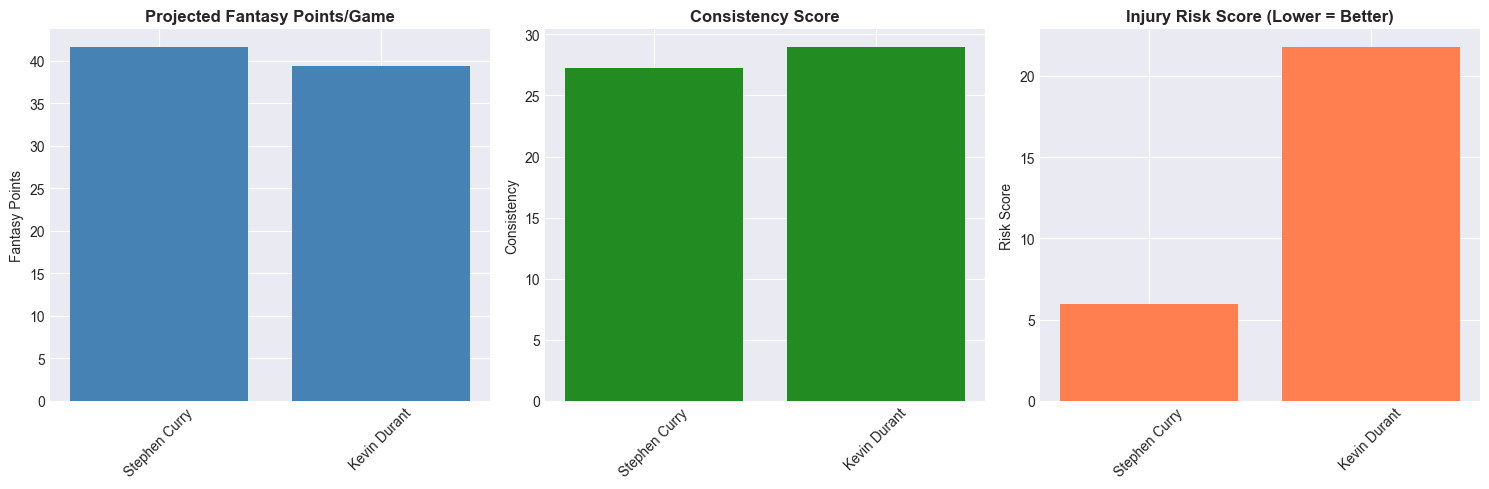

In [16]:
def compare_players(player_names_list):
    """Compare multiple players side by side"""
    comparison = rankings[rankings['player_name'].isin(player_names_list)][
        ['player_name', 'overall_rank', 'adjusted_projection', 'consistency_score',
         'floor', 'ceiling', 'injury_risk_score', 'age']
    ].sort_values('overall_rank')
    
    print("\nPLAYER COMPARISON:")
    print("=" * 100)
    display(comparison)
    
    # Visual comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Projection comparison
    axes[0].bar(comparison['player_name'], comparison['adjusted_projection'], color='steelblue')
    axes[0].set_title('Projected Fantasy Points/Game', fontweight='bold')
    axes[0].set_ylabel('Fantasy Points')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Consistency comparison
    axes[1].bar(comparison['player_name'], comparison['consistency_score'], color='forestgreen')
    axes[1].set_title('Consistency Score', fontweight='bold')
    axes[1].set_ylabel('Consistency')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Injury risk comparison (lower is better)
    axes[2].bar(comparison['player_name'], comparison['injury_risk_score'], color='coral')
    axes[2].set_title('Injury Risk Score (Lower = Better)', fontweight='bold')
    axes[2].set_ylabel('Risk Score')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example: Compare similar-ranked players
compare_players(['Stephen Curry', 'Luka Doncic', 'Kevin Durant'])

## Bonus: Position Scarcity Analysis

Analyze which positions have the most depth

In [ ]:
# Note: This requires position data which we don't have in the current dataset
# You would need to manually add position eligibility
# or scrape it from another source (Yahoo, ESPN, etc.)

print("Position scarcity analysis requires position eligibility data.")
print("To add this feature, you would need to:")
print("  1. Scrape position data from Yahoo Fantasy Basketball")
print("  2. Merge with rankings DataFrame")
print("  3. Analyze top players by position")
print("\nFor now, manually verify positions on Yahoo's website.")

## Final Checklist Before Draft

**Pre-Draft (Day Before):**
- [ ] Rerun entire notebook for fresh data
- [ ] Review top 50 players
- [ ] Check injury news for top prospects
- [ ] Print or save Excel guide

**Draft Day (30 min before):**
- [ ] Update your draft position in Step 6
- [ ] Initialize draft tracker
- [ ] Have Excel guide open
- [ ] Test player search function

**During Draft:**
- [ ] Mark each pick as it happens
- [ ] Review top available after each pick
- [ ] Balance positions (don't draft 3 centers!)
- [ ] Trust the consistency scores for early rounds
- [ ] Take upside swings in late rounds

**Good luck! 🏀**